# Autoencoders and Variants

In this notebook, we will construct basic deterministic autoencoders, a type of unsupervised representation useful for compression, reconstruction, denoising, dimensionality reduction, etc....


We will do it with MNIST, without using any labels.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('We are using the GPU: %s ' % torch.cuda.is_available())

We are using the GPU: True 


In [2]:
datadir = './data/MNIST/'

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(datadir, train=True, download=True, 
                   transform=transforms.ToTensor()),
                   batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(datadir, train=False, download=True, 
                   transform=transforms.ToTensor()),
                   batch_size=10, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



## Basic Autoencoder

Let's begin with the simplest autoencoder: a single fully connected layer as an encoder and decoder.


In [4]:
class BasicAutoEncoder(nn.Module):
    def __init__(self, input_size, code_size): # code z is the latent dir size (typically 10,5, 15, 20 etc)
        super(BasicAutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_size, code_size)
        self.decoder = nn.Linear(code_size, input_size)

    def forward(self, x):
        enc = F.relu(self.encoder(x))
        dec = self.decoder(enc)
        return dec

In [7]:
input_size = 784 # 28 x 28
code_size = 128 # picked this b/c the encoder is too simple 

model = BasicAutoEncoder(input_size, code_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

#### Exercises

1. Why did we take 784 as input dimension?
2. Find out the default learning rate of the [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).


Now let's define a training function.

In [8]:
def train_autoencoder(model, criterion, trainloader=None, epochs=1, optimizer=None):
    # set in train mode
    model.train() # allow your weights and biases to change

    for epoch in range(epochs):
        for i, (data, _) in enumerate(trainloader):
            data = data.view([-1, 784]).to(device) # flatten the data and then send it to the GPU
            
            optimizer.zero_grad() # initialize grad to zero
            output = model(data)
            loss = criterion(output, data)
            loss.backward()

            # each 100 or so minibatches print some stuff
            optimizer.step()
            if i % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(data), len(trainloader.dataset),
                    100. * i / len(trainloader), loss.data.item()))

In [9]:
train_autoencoder(model, criterion, trainloader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.121005
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.027934
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.018675
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.014446
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.012272
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.012097
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.010326
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.010560
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.008972
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.009530
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.008917
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.008270
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.007913
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.007700
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.007584
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007615
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.007223
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.007739
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.007247
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.007430
Train Epoch: 4 [0/60

### Plotting Functions

Let's check the quality of our results. First define a couple functions to help plotting the images.

In [10]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def show_recons(model, dataloader=test_loader):
    """
    Plot 10 reconstructed images from the test set. The top row is the original digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(dataloader)) 
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)

    orig = data
    encoded = model.encoder(data)
    decoded = model.decoder(encoded)
    
    orig = to_img(orig)
    decoded = to_img(decoded)
    encoded = encoded.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

        # original image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(orig[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # show code as image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

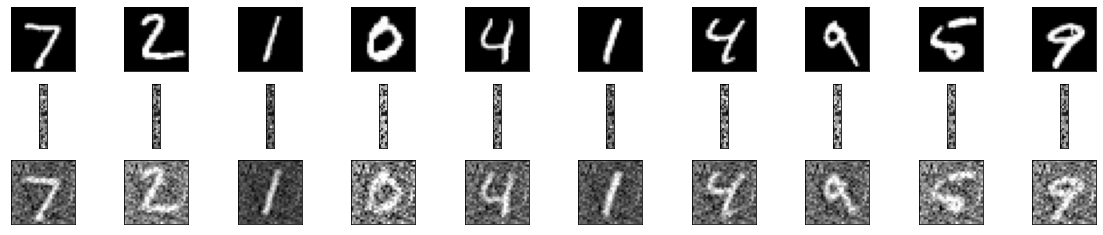

In [11]:
show_recons(model)

## Stack Layers

This was very basic and results are not so great. Up to you now to do something better:

Exercises:
1. Create a `StackAutoEncoder` model where both the encoder and the decoder are MLPs. For example, the encoder a first hidden layer of size 128, a second layer with size 64, and the code with size 32. For the decoder, you can do the reverse (symmetric autoencoder). Try to re-use the `self.encoder` and `self.decoder` functions.
2. Vary the latent code dimension, e.g to 64, or 256 and compare your results
3. Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. What is Binary Cross-Entropy? Does it make sense?


In [12]:
class StackAutoEncoder(nn.Module):
    def __init__(self, input_size, code_size):
        super(StackAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, code_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def forward(self, x):

        enc = self.encoder(x)
        dec = self.decoder(enc)
      
        return dec

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.114190
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.055763
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.039644
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.034626
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.030545
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.029462
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.027834
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.025747
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.023434
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.025094
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023744
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.023106
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.024649
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.022060
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.022181
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022906
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.020799
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.021938
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.021386
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.018790
Train Epoch: 4 [0/60

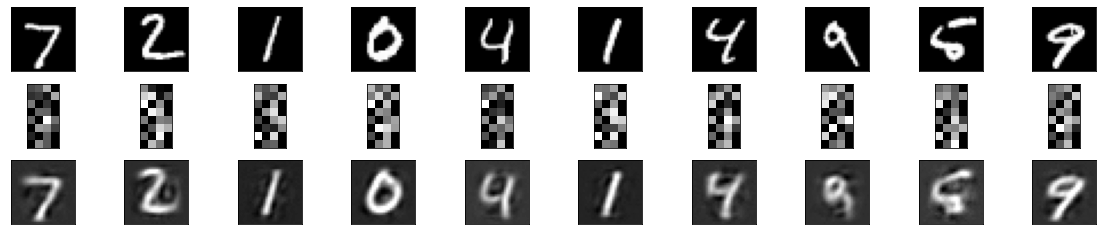

In [13]:
input_size = 784
code_size = 32 # able to do this because the encoder is more powerful

model = StackAutoEncoder(input_size, code_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()
train_autoencoder(model, criterion, trainloader=train_loader, epochs=10, optimizer=optimizer)
show_recons(model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.675916
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.124993
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.114738
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.108152
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.107499
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.103648
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.100643
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110380
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.106794
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.105134
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.104143
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.100442
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.097619
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.097361
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.098447
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.102856
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.095814
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.096632
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.095160
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.101692
Train Epoch: 4 [0/60

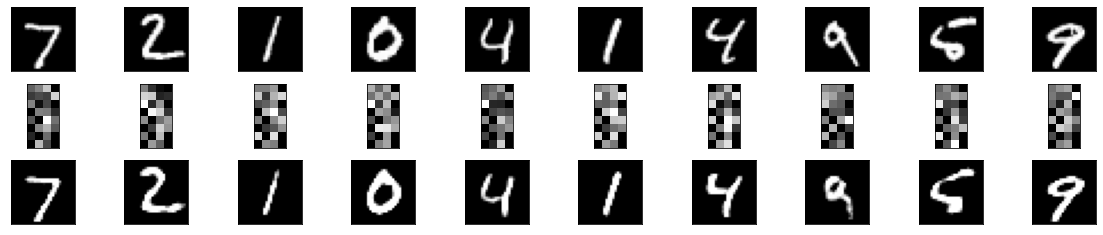

In [14]:
criterion = torch.nn.BCEWithLogitsLoss() # binary classification loss function
train_autoencoder(model, criterion, trainloader=train_loader, epochs=10, optimizer=optimizer)
show_recons(model)

## Latent Exploration

We are obtaining decent reconstructions. We are ready to see what is happening between two data sample, i.e. we want to interpolate within the latent space.

To get an intuition of the latent representation, we can pick two samples $\mathbf{x}_1$  and $\mathbf{x}_2$ and interpolate samples along a line in the latent space: the line bewteen the codes obtained by the encoder is defined by: 

$$
(1-\alpha)f(\mathbf{x}_1) + \alpha f(\mathbf{x}_2),\,\text{with}\, \alpha\in [0,1].
$$
We use the decoder $g$ to in the original space from this code in the latent space:
$$
g(1-\alpha)f(\mathbf{x}_1) + \alpha f(\mathbf{x}_2))
$$

Exercises: show interpolated samples!

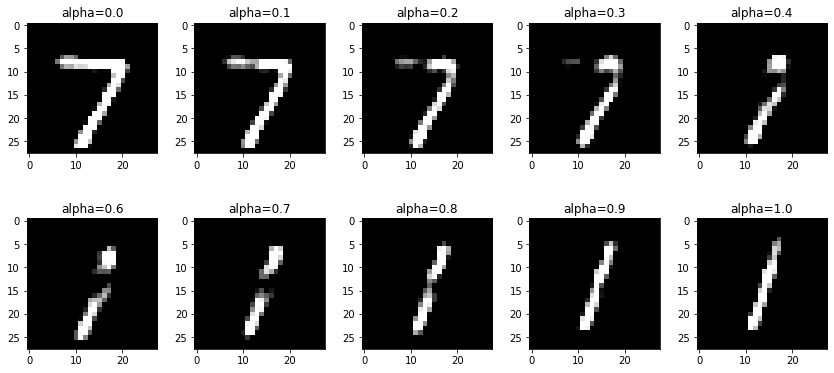

In [15]:
def autoencoder_interpolate(alpha, model, image1, image2):
    # Encode both images
    z1 = model.encoder(image1.view(-1, 784).to(device))
    z2 = model.encoder(image2.view(-1, 784).to(device))

    # Interpolate in latent space
    z_interp = (1 - alpha) * z1 + alpha * z2

    # Decode the interpolated image
    x_interp = model.decoder(z_interp)
    return x_interp
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img, label in test_loader:
    for i in range(img.size(0)):
        digits[label[i]].append(img[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

alpha_range = np.linspace(0,1,10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

autoencoder = model.eval()
for ind,l in enumerate(alpha_range):
    image_in = autoencoder_interpolate(float(l), autoencoder, digits[7][0], digits[1][0])
    image_in = to_img(image_in)
    #image = image_in.numpy()
   
    axs[ind].imshow(image_in.reshape(28,28), cmap='gray')
    axs[ind].set_title('alpha='+str(round(l,1)))

plt.show() 

# Denoising Autoencoder


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code amd the last line is the denoised digit obtained by your decoder from the code.

In [16]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch

def addnoise():
  # your code here

def train_denoising_autoencoder(model, loss_fn, data_loader=None, epochs=1, optimizer=None):
    model.train()
    for epoch in range(epochs):
      for i, (noiseless, _) in enumerate(train_loader):
        #
        # your code here to create the noisy version of noiseless using addnoise(...) function
        #
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, noiseless)
        loss.backward()
        optimizer.step()
            
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(trainloader.dataset),
                100. * i / len(trainloader), loss.data.item()))

IndentationError: ignored

In [17]:
input_dim = 784
encoding_dim = 32

model = StackAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

train_denoising_autoencoder(model, criterion, trainloader=train_loader, epochs=10, optimizer=optimizer)

NameError: ignored

In [ ]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

In [18]:
plot_denoising(model, noise=0.8)

NameError: ignored

In [19]:
# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

SyntaxError: ignored

In [20]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 16, 32, 32])

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [ ]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [ ]:
convt(y).shape

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!